## Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
## Mobile Games AB Testing with Cookie Cats

In [32]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm

import statsmodels.stats.power as ssp
import scipy.stats as stats

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [2]:
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


#### Найдем выбросы и удалим их из нашего датафрейма

[]

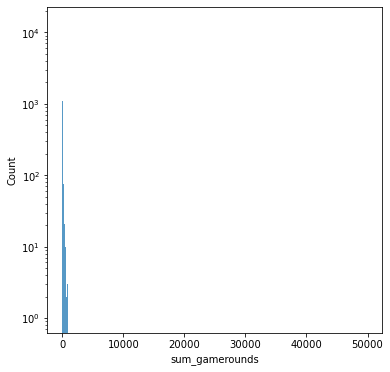

In [7]:
plt.figure(figsize=(6, 6))
sns.histplot(df['sum_gamerounds'])
plt.semilogy()

In [8]:
df.query('sum_gamerounds > 1000')

,userid,version,sum_gamerounds,retention_1,retention_7
655,69927,gate_30,1906,1,1
1097,121303,gate_30,1374,1,1
2257,248748,gate_30,1309,1,1
2586,284610,gate_30,1252,1,1
2692,294376,gate_40,1315,1,1
...,...,...,...,...,...
85964,9521620,gate_40,1252,1,1
86047,9530845,gate_40,1145,1,1
86904,9628337,gate_40,1082,1,1
87007,9640085,gate_30,2156,1,1


In [9]:
df = df.query('sum_gamerounds < 1000')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


(array([7.7673e+04, 7.2440e+03, 2.5800e+03, 1.2220e+03, 6.0300e+02,
        3.4900e+02, 1.8400e+02, 1.1300e+02, 7.0000e+01, 3.3000e+01]),
 array([  0. ,  99.7, 199.4, 299.1, 398.8, 498.5, 598.2, 697.9, 797.6,
        897.3, 997. ]),
 <BarContainer object of 10 artists>)

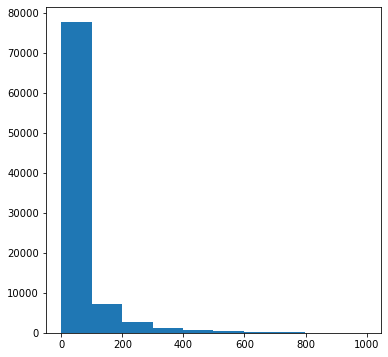

In [10]:
plt.figure(figsize=(6, 6))
plt.hist(df['sum_gamerounds'])

<AxesSubplot:xlabel='sum_gamerounds'>

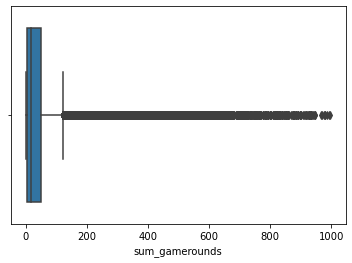

In [11]:
sns.boxplot(x=df.sum_gamerounds)

так вроде лучше, но я не уверен, стоит ли удалять все что за усами? примерно за 200, или просто этот график не совсем подходящий для лучшего отображения ситуации? посоветуйте пожалуйста в коментарии к проверке дз

In [12]:
len(df[df['version'] == 'gate_30']) + len(df[df['version'] == 'gate_40']) == df.shape[0]

True

In [13]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [14]:
df.retention_1.unique()

array([0, 1], dtype=int64)

In [15]:
df.retention_7.unique()

array([0, 1], dtype=int64)

Выбросов больше нет

#### приступим к анализу данных

In [16]:
len(df[df['version'] == 'gate_30'])

44647

In [17]:
len(df[df['version'] == 'gate_40'])

45424

выборки примерно одинаковые

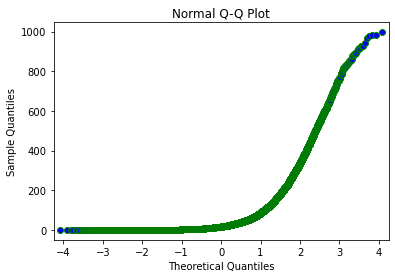

In [18]:
fig = sm.qqplot(df[df.version == 'gate_30'].sum_gamerounds, color='green')
plt.title('Normal Q-Q Plot')
plt.show;

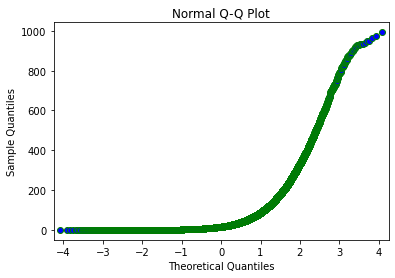

In [19]:
fig = sm.qqplot(df[df.version == 'gate_40'].sum_gamerounds, color='green')
plt.title('Normal Q-Q Plot')
plt.show;

уже по графикам видно что данные распределены не нормально, метод Шапиро-Уилко мы использовать не можем так как данных в каждой из выборок больше 5000, используем метод Колмагорова

In [20]:
print(stats.kstest(df[df.version == 'gate_30'].sum_gamerounds, 'norm'))
print(stats.kstest(df[df.version == 'gate_40'].sum_gamerounds, 'norm'))

KstestResult(statistic=0.8722932080298709, pvalue=0.0)
KstestResult(statistic=0.8705661766111726, pvalue=0.0)


убедились в том что наши данные не нормального распределения

In [21]:
stats.ttest_ind(df[df.version == 'gate_30'].sum_gamerounds,
          df[df.version == 'gate_40'].sum_gamerounds, equal_var = False)

Ttest_indResult(statistic=0.558396552424921, pvalue=0.5765750151466942)

В данном случае тест Стьюдента не объективен

In [22]:
stats.mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds,
             df[df.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1006123422.5, pvalue=0.021413207467594772)

по тесту Манна-Уитни, мы видим что pvalue < alpha = 5% что говорит о том что стоит выбрать альтернативную гипотезу, используем метод bootstrap

In [36]:
array_a = df[df.version == 'gate_30'].sum_gamerounds.values
array_b = df[df.version == 'gate_40'].sum_gamerounds.values

In [37]:
b = bs.bootstrap_ab(array_a, array_b, stat_func=bs_stats.mean, compare_func=bs_compare.difference, \
                    alpha=0.05, num_iterations=10_000)
print(b.lower_bound, b.upper_bound)

-0.8356931306221758 1.552241946487699


0 входит в доверительный интервал что нам говорит о том что статистически значимсых различий нет, но он очень близок к одному из краев интервала, посмотрим на данные чуть-чуть иначе

#### разделим наши данные на 2 группы

In [23]:
bins = [0, 1, 3, 5, 8, 10, 15, 20, 25, 30, 50, 100, 200]

A = df[df.version == 'gate_30']
pd.cut(A['sum_gamerounds'], bins=bins).value_counts()
B = df[df.version == 'gate_40']
pd.cut(B['sum_gamerounds'], bins=bins).value_counts()

(50, 100]     5386
(30, 50]      4593
(1, 3]        4467
(10, 15]      3945
(5, 8]        3726
(100, 200]    3672
(3, 5]        3348
(15, 20]      3057
(0, 1]        2789
(20, 25]      2230
(8, 10]       1929
(25, 30]      1672
Name: sum_gamerounds, dtype: int64

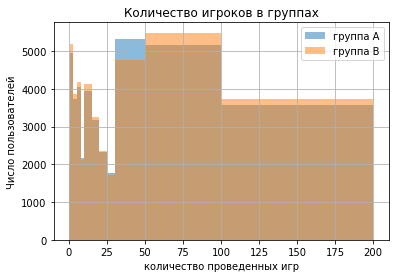

In [24]:
A.sum_gamerounds.hist(bins = bins, alpha =0.5, label='группа A')
B.sum_gamerounds.hist(bins = bins, alpha =0.5, label='группа B')
plt.title('Количество игроков в группах')
plt.xlabel('количество проведенных игр')
plt.ylabel('Число пользователей')
plt.legend();

здесь мы видим что разница между подгруппами практически миниммальна

In [41]:
A.query('retention_1 != 0').sum_gamerounds.sum() / len(A)

40.83553206262459

In [43]:
A.query('retention_7 != 0').sum_gamerounds.sum() / len(A)

28.911013057988217

In [42]:
B.query('retention_1 != 0').sum_gamerounds.sum() / len(B)

40.414846777034164

In [44]:
B.query('retention_7 != 0').sum_gamerounds.sum() / len(B)

28.388759246213457

In [27]:
A.retention_1.sum() / len(A)

0.4476000627141801

In [28]:
B.retention_1.sum() / len(B)

0.4415287072912997

In [29]:
A.retention_7.sum() / len(A)

0.18924003852442495

In [30]:
B.retention_7.sum() / len(B)

0.18087354702359987

здесь мы видим что игроки из группы gate_30, задерживаются в игре дольше и проводят немного больше боев чем другая группа. Явных различий между ними мы не наблюдаем но из неявных первая группа все же смотрится лучше